In [154]:
! python.exe -m pip install --upgrade pip
! pip install scipy; pandas; tqdm

In [155]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [156]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

In [157]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)


100%|██████████| 1100/1100 [16:59<00:00,  1.08it/s]


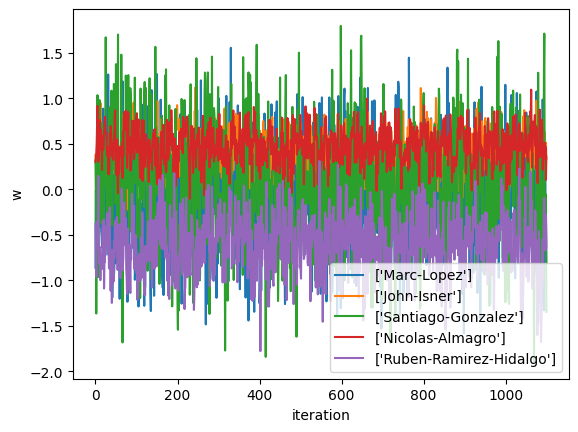

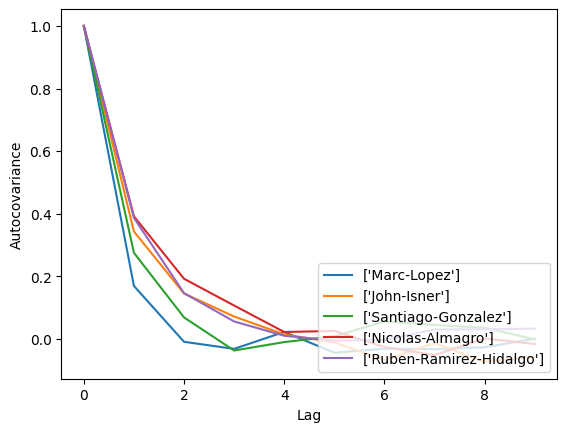

In [158]:
players = np.random.randint(0,M,5) #5 random players

# Code for plotting the autocorrelation function for player p
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.set_xlabel('iteration')
ax1.set_ylabel('w')

fig2=plt.figure()
ax2=fig2.add_subplot(111)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocovariance')

for p in players:
    # plt.subplot(2,1,1)
    ax1.plot(skill_samples[p],label=W[p])
    autocor = np.zeros(10)
    for i in range(10):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
    ax2.plot(autocor,label=W[p])

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
plt.show()

In Gibbs sampling, burn-in period is the initial sequence of samples that are discarded before the chain reaches the stationary distribution. When we have reached the stationary distribution, the probability distribution of the states (skills of each player) remain constant over time. Therefore we can estimate the burn-period to be the iteration taken for the running-average to stay constant, we can also observe the running-variance.

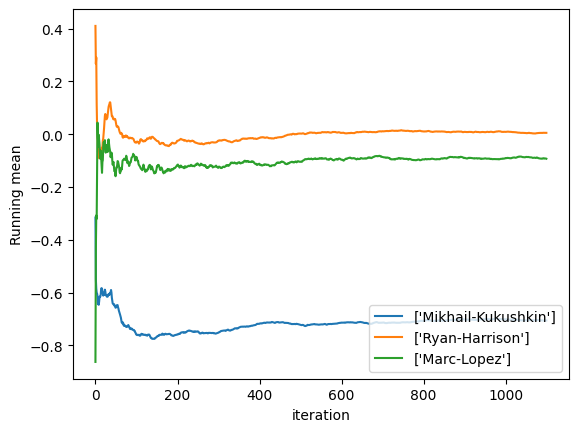

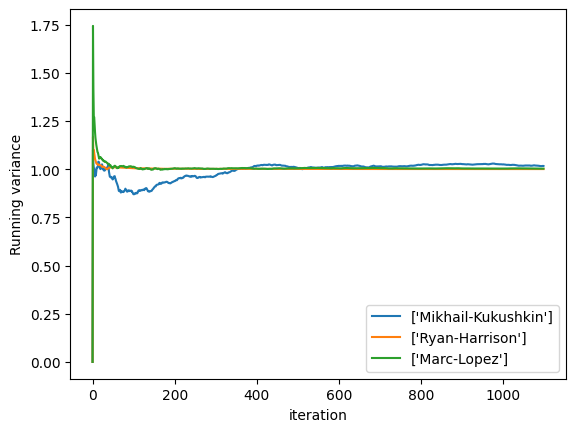

In [159]:
players = np.random.randint(0,M,3) #3 random players

# Code for plotting the moving-mean for player p
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.set_xlabel('iteration')
ax1.set_ylabel('Running mean')

# Code for plotting the moving-variance for player p
fig2=plt.figure()
ax2=fig2.add_subplot(111)
ax2.set_xlabel('iteration')
ax2.set_ylabel('Running variance')

def runningMean(arr):
    for i in range(1,len(arr)):
        arr[i]=(arr[i-1]*(i)+arr[i])/(i+1)

    return arr

def runningVar(mean,arr):
    '''Computed as mean of the squares minus the square of the mean'''
    
    sumx2=[]
    var=[]
    for i in range(len(arr)):
        if i==0:
            sumx2.append(arr[i]**2)
            var.append(0)
        else:
            sumx2.append(sumx2[-1]+arr[i]**2)
            var.append(sumx2[-1]/i+1 - mean[i]**2)
    
    return var

for p in players:
    mean = runningMean(skill_samples[p][:])
    ax1.plot(mean,label=W[p])
    var = runningVar(mean, skill_samples[p][:])
    ax2.plot(var,label=W[p])

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
plt.show()

We see mean and variance start to converge after ~ 200 iteration. Therefore we discard the first 200 samples.

Observering the autocovariance coefficient we see that samples are generated approximately independent of each other after a lag of around 5. So we perform thinning by taking only every 5th sample.

The computation complexity of running the Gibbs Sampler is O(iter * N^3), where the most expensive N^3 comes from the Choleskey factorization of the precision matrix.

# EP ranking

Convergence in Gibbs sampling is the iteration when we have discarded the effects of initial values (starting point) and is now effectively sampling randomly from the desired distribution, which is the stationary distribution of the skill marginals. Therefore upon convergence we can obtain a certain mean and variance value. 

In message passing algorithm, we are just calculating marginal distribution for each unobserved node, conditional on any observed node. When infering the marginal distribution for the players skill, we initialise at some value that propagates through the graph to give us the performance marginals, then we propagate the performance marginals in the opposite direction to update our skill marginals, repeating this until the skill marginal values stay approximately constant. 

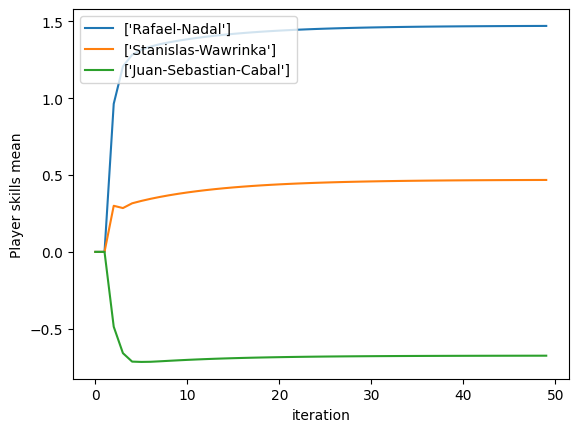

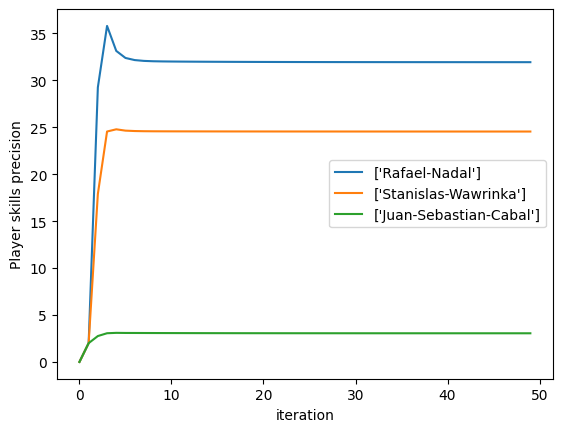

In [160]:
players = np.random.randint(0,M,3) #3 random players

# Code for plotting the mean for players 
fig1=plt.figure()
ax1=fig1.add_subplot(111)

# Code for plotting the precision for players 
fig2=plt.figure()
ax2=fig2.add_subplot(111)

mean_iter=[[] for _ in range(len(players))]
precision_iter=[[] for _ in range(len(players))]

for num_iters in range(50):
    # run message passing algorithm, returns mean and precision for each player
    mean_player_skills, precision_player_skills = eprank(G, M, num_iters)
    for i,p in enumerate(players):
        mean_iter[i].append(mean_player_skills[p])
        precision_iter[i].append(precision_player_skills[p])

ax1.plot(list(zip(*mean_iter)),label=[W[p] for p in players])
ax1.set_xlabel('iteration')
ax1.set_ylabel('Player skills mean')
ax1.legend()

ax2.plot(list(zip(*precision_iter)),label=[W[p] for p in players])
ax2.set_xlabel('iteration')
ax2.set_ylabel('Player skills precision')
ax2.legend()
plt.show()


Convergence in Gibbs is when we sample to the point that the empirical mean of some function sampled from the distribution converges to the expected value of said function under this distribution.

Convergence in EP is when the approximated marginals starts staying constant.

We can see that for EP, it takes around 40 iteration for the marginal skills mean to stay converge. Gibbs requires at least 200 iterations for burn-in and then 500 samples after (since we discard 4/5) for 100 independent samples.

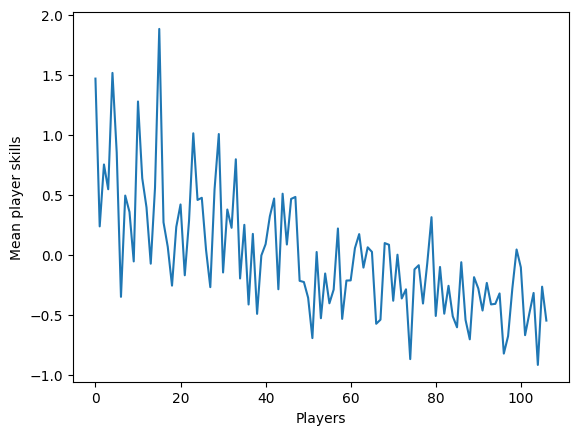

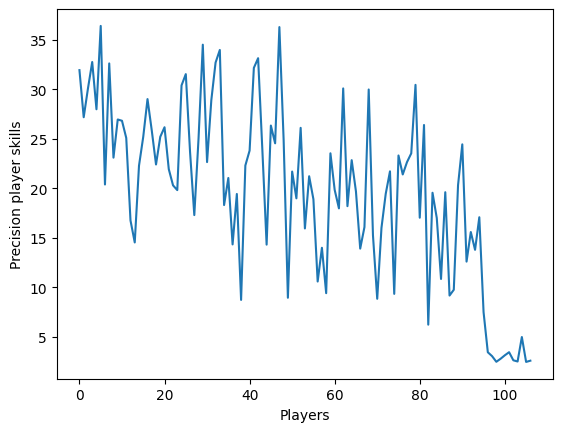

In [161]:
plt.plot(mean_player_skills)
plt.xlabel('Players')
plt.ylabel('Mean player skills')
plt.show()
plt.plot(precision_player_skills)
plt.xlabel('Players')
plt.ylabel('Precision player skills')
plt.show()

#Q3

In [162]:
#Linear search for top-4 player index
topfour=['Novak-Djokovic','Rafael-Nadal','Roger-Federer','Andy-Murray']
for i,p in enumerate(topfour):
    for j,name in enumerate(W):
        if name==p:
            topfour[i]=j

print(topfour)


[15, 0, 4, 10]


The probability of one player's skill,wI, being higher than the other, wJ, is simply:

P(wI-wJ>0), where we take wI-wJ as the random variable, this would just be computed as the CDF of probability distribution

P(wI-wJ) ~ N(muI-muJ,inverse(precisionI+precisionJ))

The probability of one player,i, winning the match between i,j however, is probability that the performance, t has a sign of 0 

t ~ N(wI-wJ,1) is the random variable.

The variance of 1 approximates noise and random events in the real world.



In [163]:
import scipy.stats as stats

In [164]:
# Using message passing algorithm 
skill_matrix=[[0 for _ in range(4)] for _ in range(4)]
winning_matrix=[[0 for _ in range(4)] for _ in range(4)]
for x,i in enumerate(topfour):
    for y,j in enumerate(topfour):
        skill_matrix[x][y]=stats.norm.cdf(mean_player_skills[i]-mean_player_skills[j],0,(1/precision_player_skills[i]+1/precision_player_skills[j])**0.5)
        winning_matrix[x][y]=stats.norm.cdf(mean_player_skills[i]-mean_player_skills[j],0,1)

print(skill_matrix)
print(winning_matrix)



[[0.5, 0.9398334833456123, 0.9088893812629764, 0.9853201792725083], [0.06016651665438768, 0.5, 0.42714221840885613, 0.7664787409075877], [0.09111061873702364, 0.5728577815911439, 0.5, 0.8108196774008409], [0.014679820727491714, 0.23352125909241228, 0.189180322599159, 0.5]]
[[0.5, 0.6604950097655913, 0.6429151412739519, 0.7271745951321434], [0.3395049902344088, 0.5, 0.4810363810014433, 0.5755317647395852], [0.3570848587260481, 0.5189636189985567, 0.5, 0.5940704072921346], [0.27282540486785656, 0.42446823526041483, 0.4059295927078654, 0.5]]


Choosing top 2 players to plot the distribution
15 and 0 

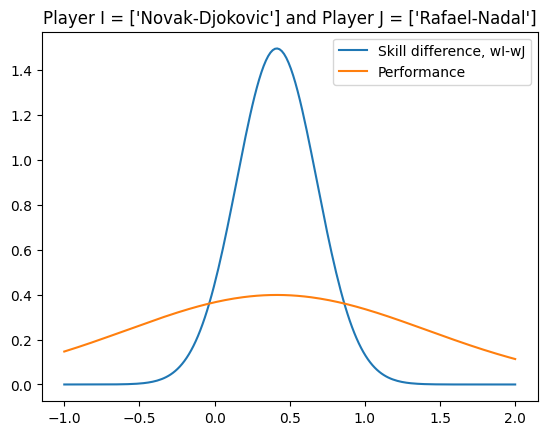

In [165]:
p1=15
p2=0

y=[]
x=np.linspace(-1,2,200)
for i in x:
    y.append(stats.norm.pdf(i,mean_player_skills[p1]-mean_player_skills[p2],(1/precision_player_skills[p1]+1/precision_player_skills[p2])**0.5))

plt.plot(x,y,label='Skill difference, wI-wJ')

y=[]
for i in x:
    y.append(stats.norm.pdf(i,mean_player_skills[p1]-mean_player_skills[p2],1))


plt.plot(x,y,label='Performance')

plt.title('Player I = {} and Player J = {}'.format(W[p1],W[p2]))
plt.legend()
plt.show()

We can see how the noise causes a greater spread and less confidence for performance compared to skill difference.

#Q4 
Using Gibbs sampling

Compare Nadal and Federer's skills based on approximating their marginal skills by Gaussians.

First we discard the first 200 samples then take only every 5th sample.
Then compute the mean and variance with the remaining samples and approximate a Gaussian with these two moments for each player.

Then similar to Q3, compute the cumulative probability of wI-wJ>0 where the mean is muI-muJ and variance is the sum of the respetive variance.

In [166]:
# Index of Nadal and Federer
Nadal = 0
Federer = 4 

skill_samples_Nadal = skill_samples[Nadal][200::5]
skill_samples_Federer = skill_samples[Federer][200::5]


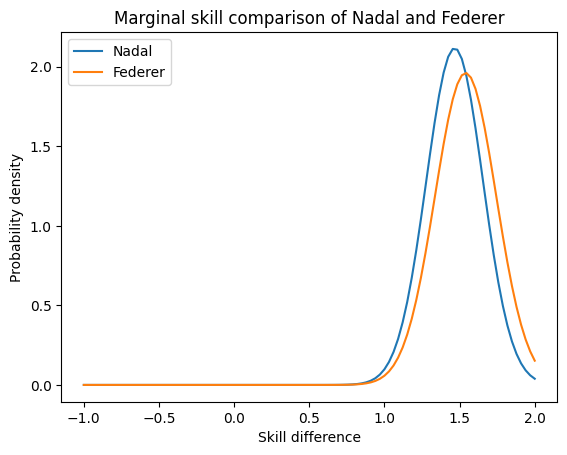

In [167]:

import statistics

# Skill comparision marginally
mean_Nadal = statistics.mean(skill_samples_Nadal)
mean_Federer = statistics.mean(skill_samples_Federer)
var_Nadal = statistics.variance(skill_samples_Nadal)
var_Federer = statistics.variance(skill_samples_Federer)

x = np.linspace(-1,2,100)

y1=[]
y2=[]
for i in x:
    y1.append(stats.norm.pdf(i,mean_Nadal,var_Nadal**0.5))
    y2.append(stats.norm.pdf(i,mean_Federer,var_Federer**0.5))

plt.xlabel('Skill difference')
plt.ylabel('Probability density')
plt.title('Marginal skill comparison of Nadal and Federer')
plt.plot(x,y1,label='Nadal')
plt.plot(x,y2,label='Federer')
plt.legend()
plt.show()



In [168]:
marginal_CDF = stats.norm.cdf(mean_Nadal-mean_Federer,0,(var_Federer+var_Nadal)**0.5)
print(marginal_CDF)

0.3961485932184683


C:\Users\Hsin\AppData\Local\Temp\ipykernel_55496\393968472.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


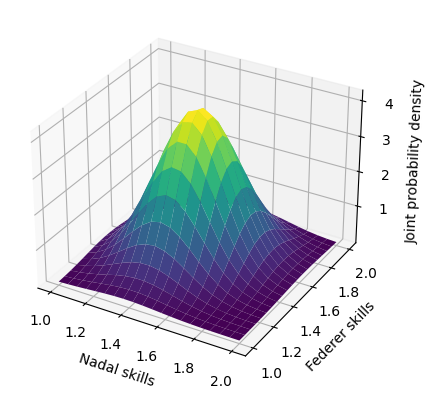

In [169]:
# Gaussian joint distribution 
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

cov_matrix = np.cov(skill_samples_Nadal,skill_samples_Federer)

# Setting range for players, creating grid
x = np.linspace(1,2,20)
y = np.linspace(1,2,20)
X, Y = np.meshgrid(x,y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
rv = multivariate_normal([mean_Nadal, mean_Federer], cov_matrix)

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('Nadal skills')
ax.set_ylabel('Federer skills')
ax.set_zlabel('Joint probability density')
plt.show()


In [170]:
print(cov_matrix)

[[0.03553656 0.00704912]
 [0.00704912 0.04139103]]


In [171]:
#Cheat way to compute area under curve 
iteration= 100000
count=0

for i in range(iteration):
    sample = np.random.multivariate_normal([mean_Nadal, mean_Federer], cov_matrix)
    if sample[0]>sample[1]:
        count+=1

joint_CDF = count/iteration
print(joint_CDF)

0.38553


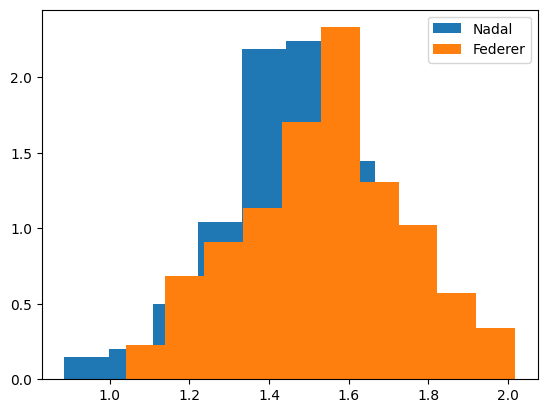

In [172]:
# Directly with Gibbs samples

plt.hist(skill_samples_Nadal,label='Nadal',density=True)
plt.hist(skill_samples_Federer,label='Federer',density=True)
plt.legend()
plt.show()

In [173]:
# Sampling CDF
count=0
for i in range(len(skill_samples_Nadal)):
    if skill_samples_Nadal[i]>skill_samples_Federer[i]:
        count+=1

samples_CDF = count/len(skill_samples_Nadal)
print(samples_CDF)

0.36666666666666664


Marginals is easy to compute, pdf of random variable is easy to computer, just add independent sum and variances. CDF essentially integrates area of a 1D Gaussian.

Joint is most complex to compute, need to sum area of a section of the 3D graph, requires many iteration to approximate the CDF.

Samples is easy to compute as well, just count occurrences of wI>wJ. However, requires many initial samples due to burn-in and thinning for accuracy. 

Given the computing power of current computer and it is only a bivariate gaussian, joint is best since the skills of players shouldn't be assumed to be independent. We can see this from the covariance matrix that the non-diagonal terms are not close to 0. So comparing performance based of joint distribution takes into account this extra information.


In [174]:
# Using joing distribution to compute 4x4 matrix of skills difference

# Using message passing algorithm 
skill_matrix=[[0 for _ in range(4)] for _ in range(4)]

Djokovic=topfour[0]
Murray=topfour[3]
skill_samples_Djokovic = skill_samples[Djokovic][200::5]
skill_samples_Murray = skill_samples[Murray][200::5]

mean_Djokovic = statistics.mean(skill_samples_Djokovic)
mean_Murray = statistics.mean(skill_samples_Murray)

means=[mean_Djokovic,mean_Nadal,mean_Federer,mean_Murray]
skills = [skill_samples_Djokovic, skill_samples_Nadal, skill_samples_Federer, skill_samples_Murray]

for i in range(4):
    skill_matrix[i][i]=0.5
    for j in range(i+1,4):
        iteration=100000
        count=0
        cov_matrix=np.cov(skills[i],skills[j])

        for iter in range(iteration):
            sample = np.random.multivariate_normal([means[i], means[j]], cov_matrix)
            if sample[0]>sample[1]:
                count+=1

        skill_matrix[i][j] = count/iteration
        skill_matrix[j][i]=1-skill_matrix[i][j]
        
print(skill_matrix)




[[0.5, 0.95407, 0.93598, 0.98399], [0.045930000000000026, 0.5, 0.38593, 0.78137], [0.06401999999999997, 0.61407, 0.5, 0.82421], [0.01600999999999997, 0.21863, 0.17579, 0.5]]


Something like values are similar, but computationally Gibbs method is much more expensive, also requires lots of samples to converge. 

#Q5



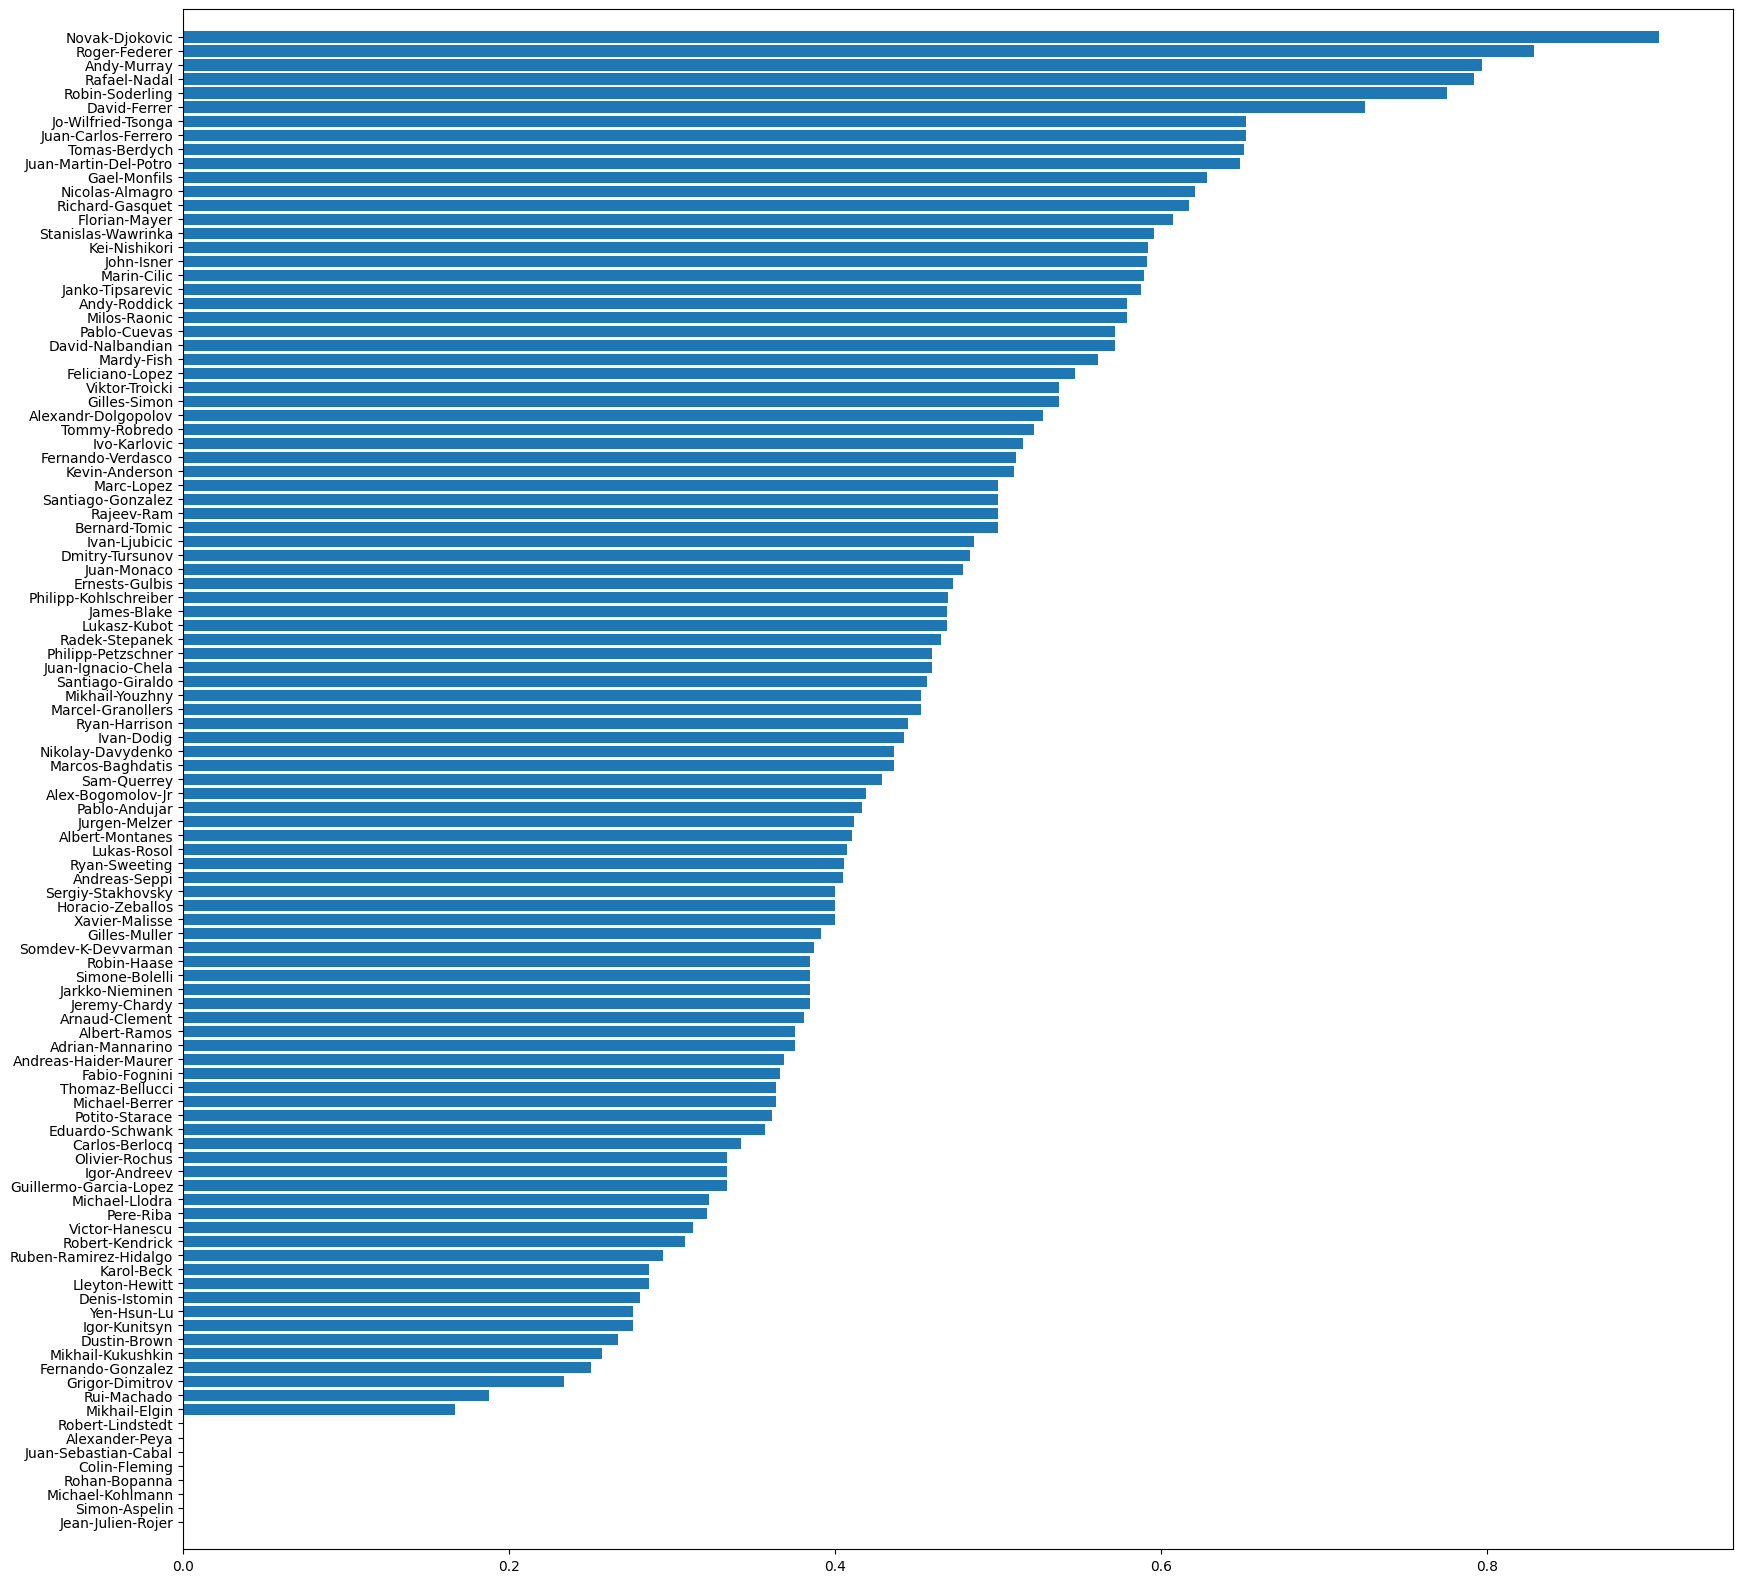

In [183]:
# Ranking with empirical game outcomes averages
# For each player, skill = number of games won/number of games played 
player_win_gamesplayed=[[0,0] for _ in range(M)] #list indexed by player --> (games won, games played)

for i,j in G:
    player_win_gamesplayed[i][1]+=1
    player_win_gamesplayed[j][1]+=1

    player_win_gamesplayed[i][0]+=1

empirical_rank = np.array([win/played for win,played in player_win_gamesplayed])
sorted_barplot(empirical_rank,W)

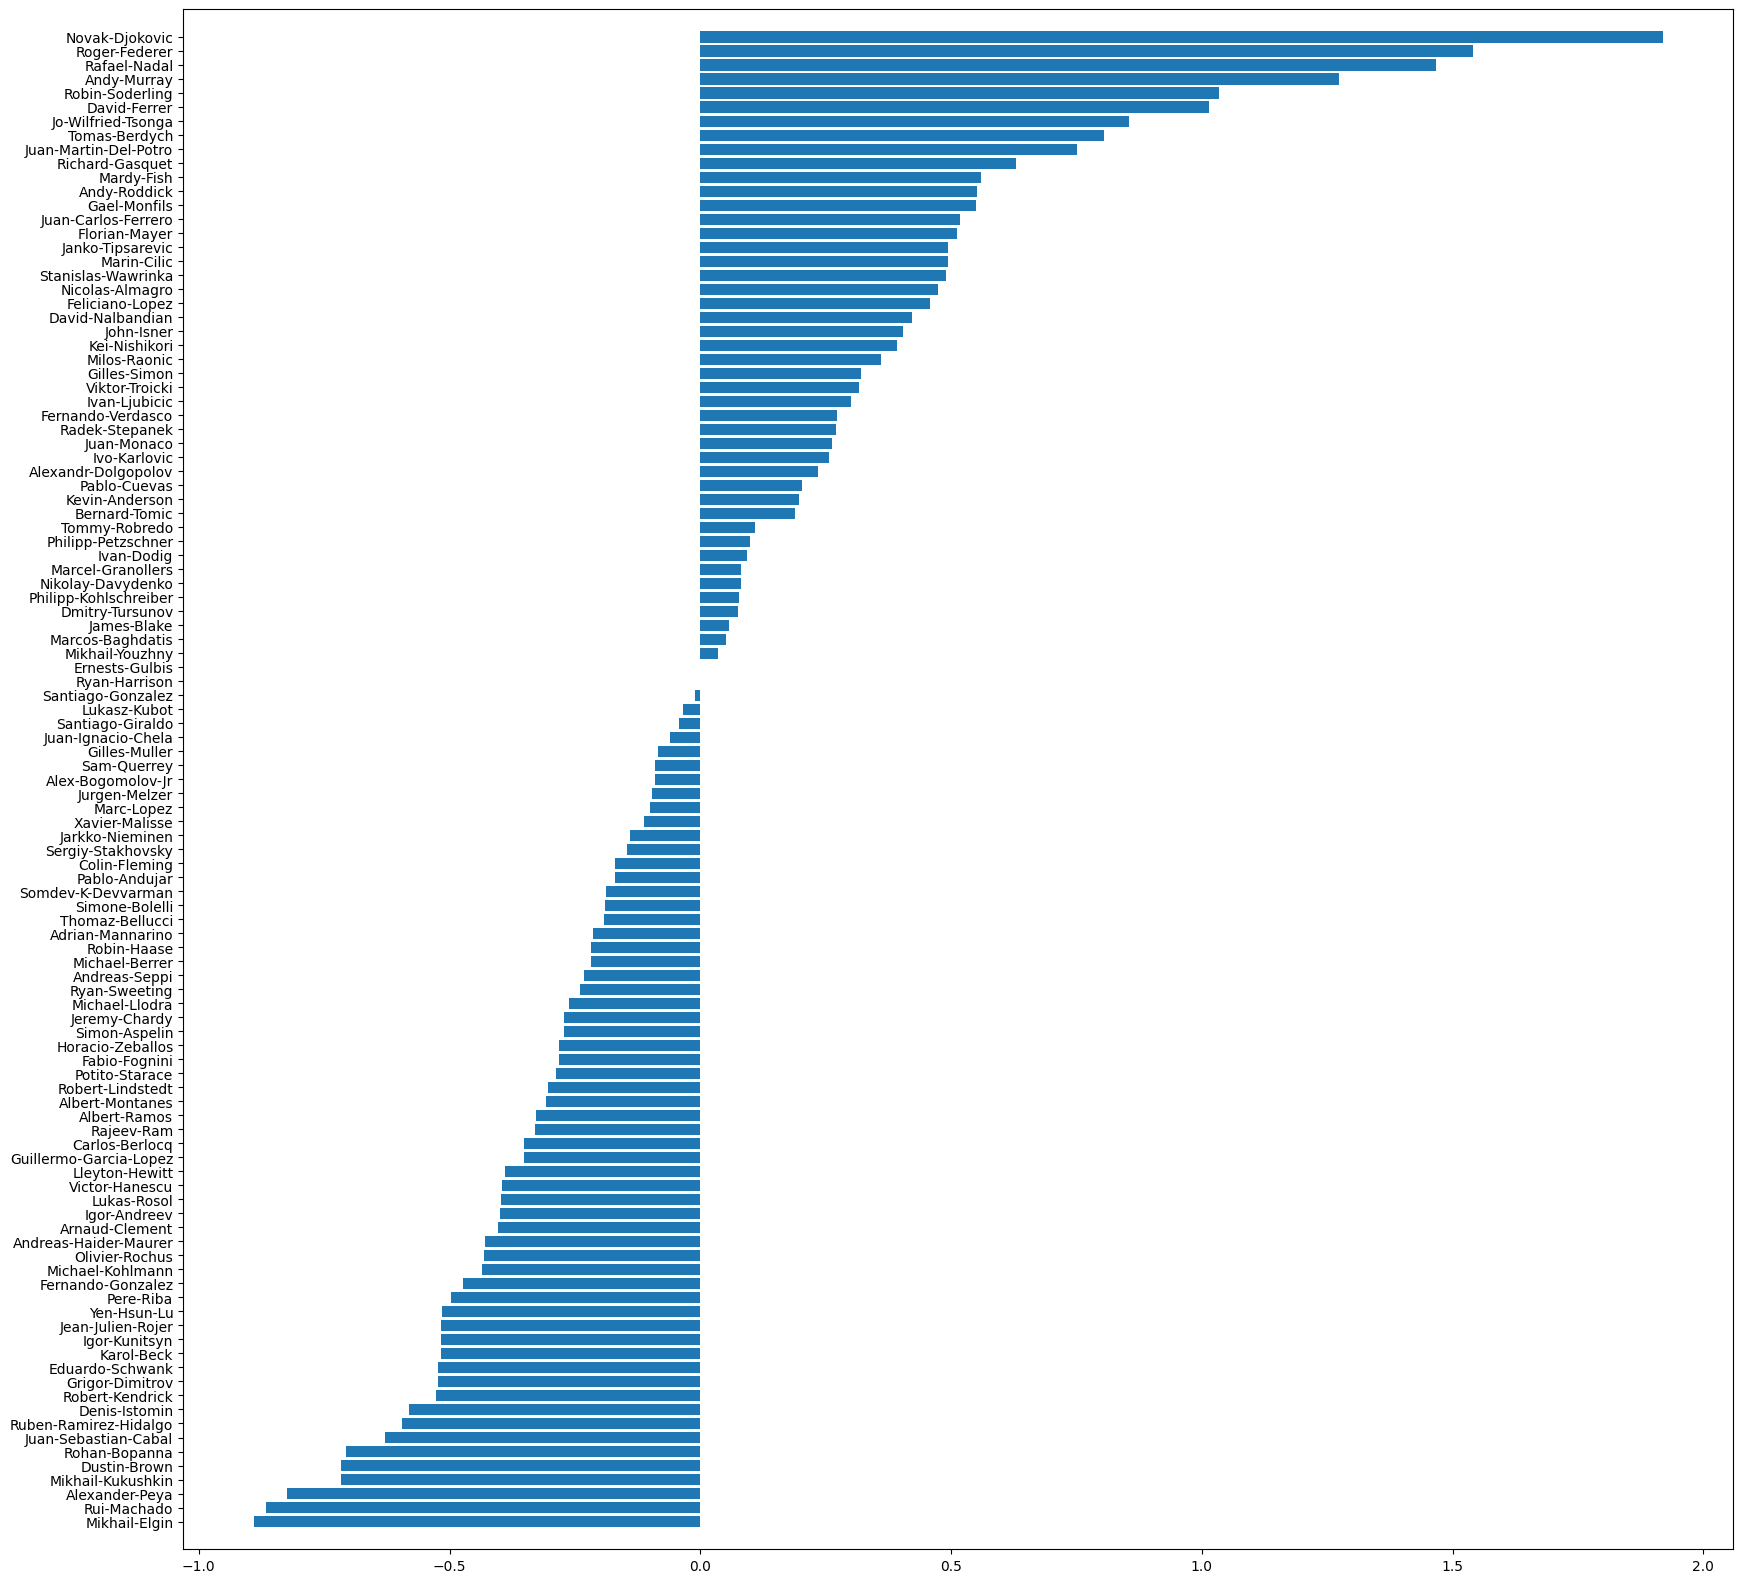

In [184]:
# Ranking with Gibbs Sampling 
means_gibbs = np.mean(skill_samples[:,200::5],axis=1)
sorted_barplot(means_gibbs,W)

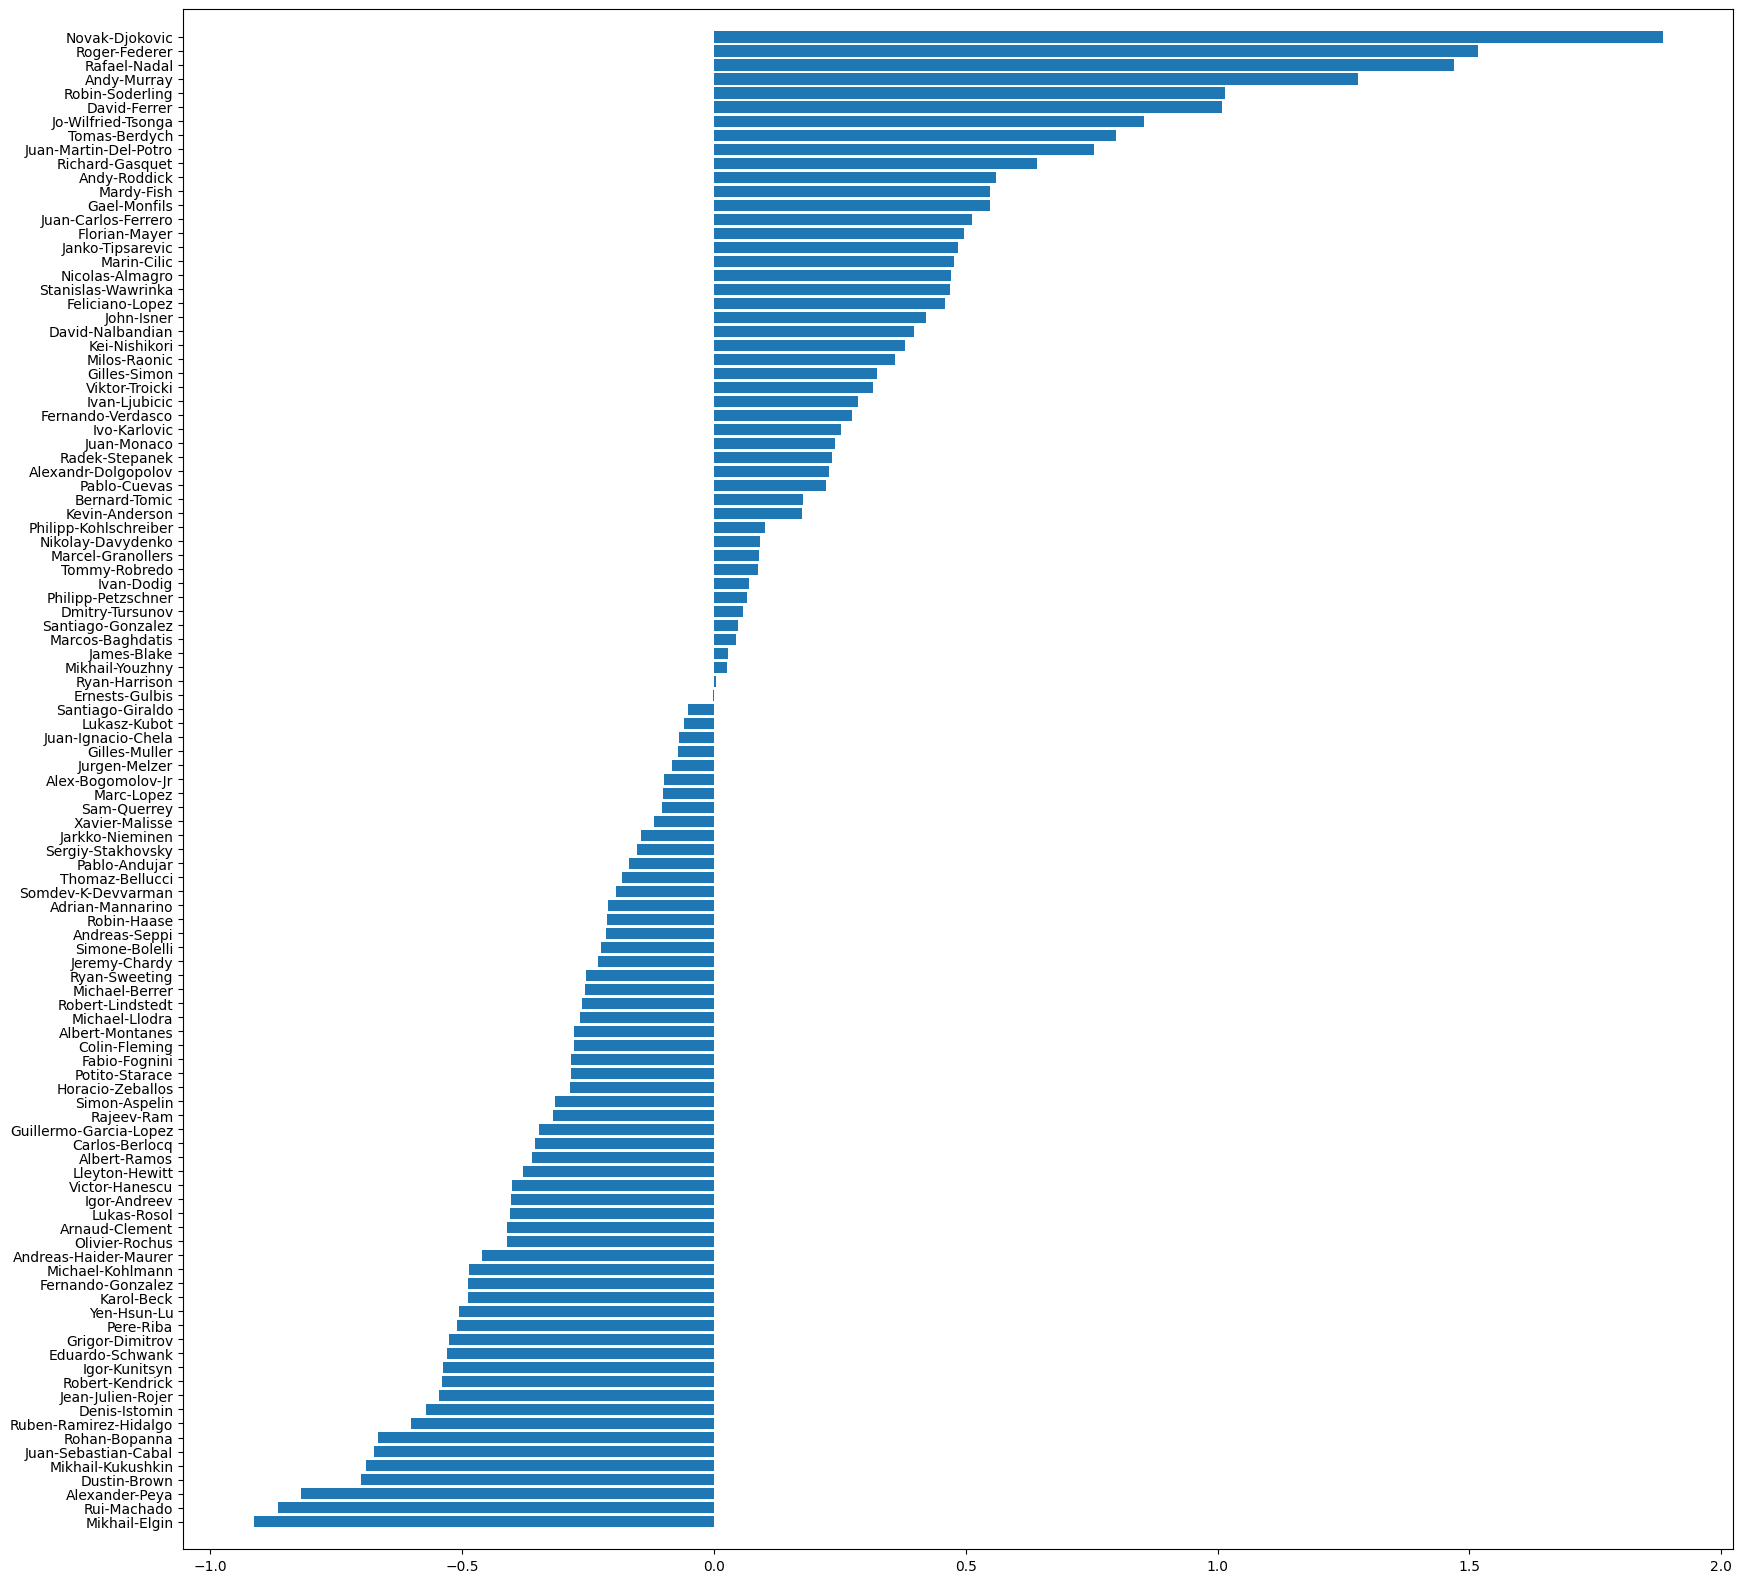

In [178]:
# Ranking with message passing algorithm
sorted_barplot(mean_player_skills,W)